In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
from torchvision import transforms

In [2]:
class CNN_EMnist(nn.Module):
    def __init__(self):
        super(CNN_EMnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(256, 128)
        self.z_log_var = nn.Linear(256, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = EMNIST(root='~/data', train=True, split = 'bymerge', download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
testset = EMNIST(root='~/data', train=False, split = 'bymerge', download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

697932 116323
5453 909


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_EMnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 30

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 354.76it/s]


Epoch: 0 - TrainRecLoss: 25.894909777729616 - ValidRecLoss: 19.330908262296873
Epoch: 0 - TrainDivLoss: 13.64383809676733 - ValidDivLoss: 15.467232061035693


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 354.91it/s]


Epoch: 1 - TrainRecLoss: 18.944290191213867 - ValidRecLoss: 19.67390676273896
Epoch: 1 - TrainDivLoss: 15.1010012289985 - ValidDivLoss: 14.042937283993291


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 353.42it/s]


Epoch: 2 - TrainRecLoss: 18.192796791800003 - ValidRecLoss: 17.609626253839373
Epoch: 2 - TrainDivLoss: 15.136281230701956 - ValidDivLoss: 15.587150400621269


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 343.74it/s]


Epoch: 3 - TrainRecLoss: 17.793529099332027 - ValidRecLoss: 17.906999400215444
Epoch: 3 - TrainDivLoss: 15.14221632828215 - ValidDivLoss: 14.929744128740266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 348.93it/s]


Epoch: 4 - TrainRecLoss: 17.51387522291879 - ValidRecLoss: 16.95784290343097
Epoch: 4 - TrainDivLoss: 15.158601090161708 - ValidDivLoss: 15.695563455881722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 348.55it/s]


Epoch: 5 - TrainRecLoss: 17.310080218179586 - ValidRecLoss: 17.36733834211058
Epoch: 5 - TrainDivLoss: 15.159493550584445 - ValidDivLoss: 15.058964160671591


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 358.07it/s]


Epoch: 6 - TrainRecLoss: 17.14494963547472 - ValidRecLoss: 17.101878670838275
Epoch: 6 - TrainDivLoss: 15.186188708308332 - ValidDivLoss: 15.215942226489647


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 362.46it/s]


Epoch: 7 - TrainRecLoss: 17.010029781417806 - ValidRecLoss: 17.236800601904672
Epoch: 7 - TrainDivLoss: 15.199376388009744 - ValidDivLoss: 14.98372475148821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 368.74it/s]


Epoch: 8 - TrainRecLoss: 16.914403531522066 - ValidRecLoss: 16.85424337187747
Epoch: 8 - TrainDivLoss: 15.19557482846916 - ValidDivLoss: 15.22462299397283


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 380.52it/s]


Epoch: 9 - TrainRecLoss: 16.81830167062082 - ValidRecLoss: 16.837804633792086
Epoch: 9 - TrainDivLoss: 15.208006524436303 - ValidDivLoss: 15.16450320454714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 380.44it/s]


Epoch: 10 - TrainRecLoss: 16.751605230450696 - ValidRecLoss: 16.218296588188483
Epoch: 10 - TrainDivLoss: 15.20522423916818 - ValidDivLoss: 15.81536787912266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 381.45it/s]


Epoch: 11 - TrainRecLoss: 16.681145605069442 - ValidRecLoss: 16.99792930342839
Epoch: 11 - TrainDivLoss: 15.204428030944802 - ValidDivLoss: 14.93465455478043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 382.40it/s]


Epoch: 12 - TrainRecLoss: 16.630964917347843 - ValidRecLoss: 16.853938987152805
Epoch: 12 - TrainDivLoss: 15.207729437537921 - ValidDivLoss: 15.039737833608495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 375.44it/s]


Epoch: 13 - TrainRecLoss: 16.58287240194002 - ValidRecLoss: 16.3277104380894
Epoch: 13 - TrainDivLoss: 15.209504938816425 - ValidDivLoss: 15.465189530904537


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 340.57it/s]


Epoch: 14 - TrainRecLoss: 16.53000581284171 - ValidRecLoss: 16.526615126035917
Epoch: 14 - TrainDivLoss: 15.213630032500017 - ValidDivLoss: 15.208180517777883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 339.83it/s]


Epoch: 15 - TrainRecLoss: 16.491027827309225 - ValidRecLoss: 16.652289896252658
Epoch: 15 - TrainDivLoss: 15.209808953329114 - ValidDivLoss: 15.100880290284277


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 374.83it/s]


Epoch: 16 - TrainRecLoss: 16.444382774923866 - ValidRecLoss: 16.394829410137515
Epoch: 16 - TrainDivLoss: 15.212239770698652 - ValidDivLoss: 15.303794662551125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 368.83it/s]


Epoch: 17 - TrainRecLoss: 16.40967544319213 - ValidRecLoss: 16.726389896489344
Epoch: 17 - TrainDivLoss: 15.20868179021178 - ValidDivLoss: 14.91751666535901


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 379.10it/s]


Epoch: 18 - TrainRecLoss: 16.375404126006224 - ValidRecLoss: 16.52433010034173
Epoch: 18 - TrainDivLoss: 15.210753678532232 - ValidDivLoss: 15.066859203334426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 382.56it/s]


Epoch: 19 - TrainRecLoss: 16.349482704210168 - ValidRecLoss: 16.150026690710757
Epoch: 19 - TrainDivLoss: 15.201967189711167 - ValidDivLoss: 15.410303535503392


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 372.36it/s]


Epoch: 20 - TrainRecLoss: 16.320164472012262 - ValidRecLoss: 16.13570913518354
Epoch: 20 - TrainDivLoss: 15.201441764831543 - ValidDivLoss: 15.442889492635024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 383.00it/s]


Epoch: 21 - TrainRecLoss: 16.296652845301892 - ValidRecLoss: 16.062339415513513
Epoch: 21 - TrainDivLoss: 15.210134203666156 - ValidDivLoss: 15.49163545791072


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 377.36it/s]


Epoch: 22 - TrainRecLoss: 16.265018306258575 - ValidRecLoss: 15.978221643613642
Epoch: 22 - TrainDivLoss: 15.208156774574391 - ValidDivLoss: 15.532519728699402


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 380.41it/s]


Epoch: 23 - TrainRecLoss: 16.245102526309534 - ValidRecLoss: 16.07382582988676
Epoch: 23 - TrainDivLoss: 15.206625821414223 - ValidDivLoss: 15.426802105373806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 383.30it/s]


Epoch: 24 - TrainRecLoss: 16.22336080894981 - ValidRecLoss: 15.879461265370923
Epoch: 24 - TrainDivLoss: 15.207016060991984 - ValidDivLoss: 15.603545998845032


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 380.09it/s]


Epoch: 25 - TrainRecLoss: 16.204537393061717 - ValidRecLoss: 16.149464686973914
Epoch: 25 - TrainDivLoss: 15.192632109402254 - ValidDivLoss: 15.273512107966626


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 392.99it/s]


Epoch: 26 - TrainRecLoss: 16.186014303784184 - ValidRecLoss: 16.112904711262754
Epoch: 26 - TrainDivLoss: 15.20390881640352 - ValidDivLoss: 15.275091342275555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 369.91it/s]


Epoch: 27 - TrainRecLoss: 16.156915775378124 - ValidRecLoss: 16.361216123348022
Epoch: 27 - TrainDivLoss: 15.20357481510338 - ValidDivLoss: 15.018556242335354


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 369.81it/s]


Epoch: 28 - TrainRecLoss: 16.14048801315786 - ValidRecLoss: 16.39271649485505
Epoch: 28 - TrainDivLoss: 15.202450237382601 - ValidDivLoss: 15.00446377492974


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:02<00:00, 376.87it/s]

Epoch: 29 - TrainRecLoss: 16.13099705335658 - ValidRecLoss: 16.048162169713525
Epoch: 29 - TrainDivLoss: 15.189005592558857 - ValidDivLoss: 15.312586025829756


In [7]:
def interpolate(autoencoder, x_1, x_2, n=20):
    z_1 = autoencoder.get_latent(x_1)[0]
    z_2 = autoencoder.get_latent(x_2)[0]
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    fig, ax = plt.subplots(figsize=(15, 2))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

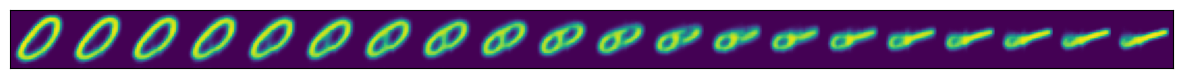

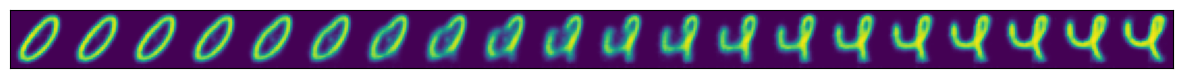

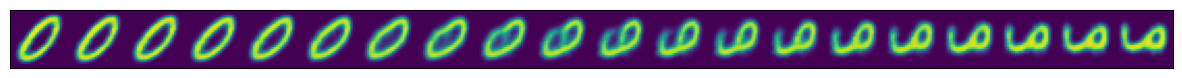

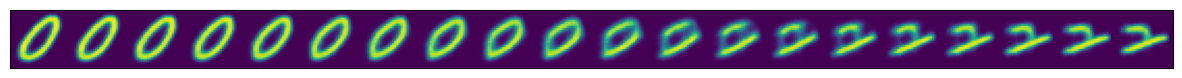

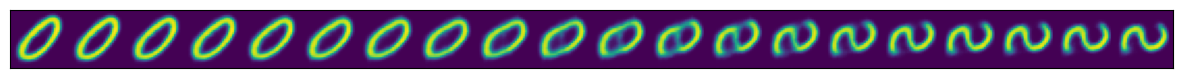

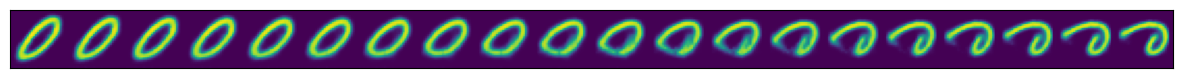

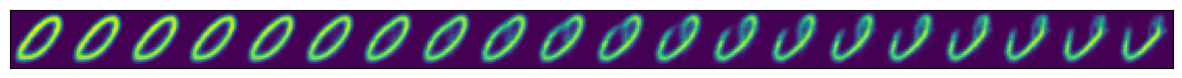

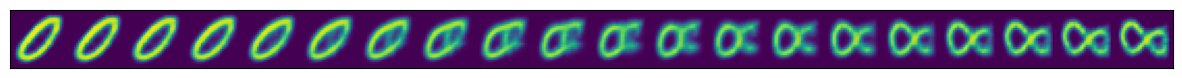

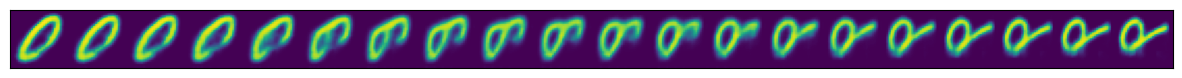

In [8]:
model.eval()
with torch.no_grad():
    x, y = next(iter(test_dl))
    x_1 = x[y == 0][1].to(device).unsqueeze(0)
    
    for idx in range(1, 10):
        x_2 = x[y == idx][1].to(device).unsqueeze(0)
        interpolate(model, x_1, x_2, n=20)

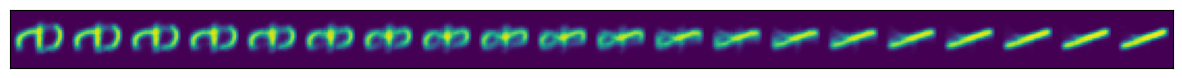

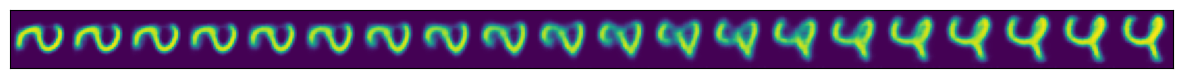

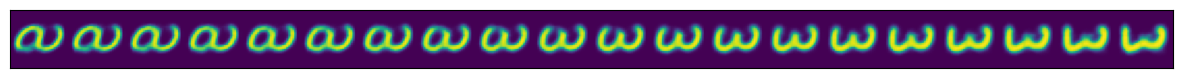

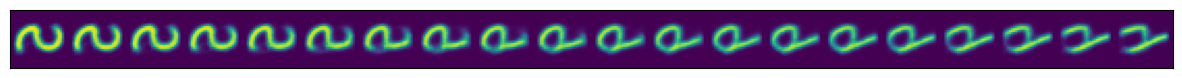

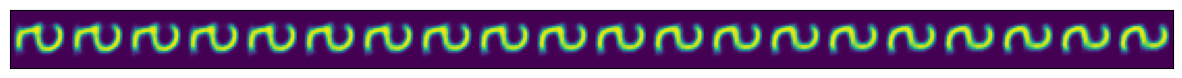

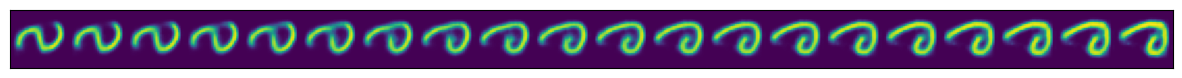

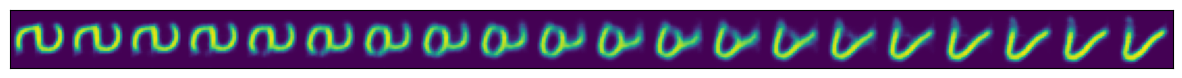

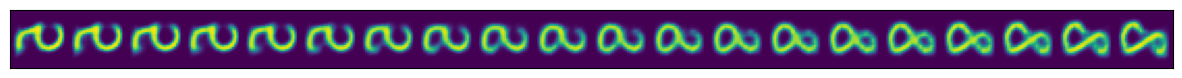

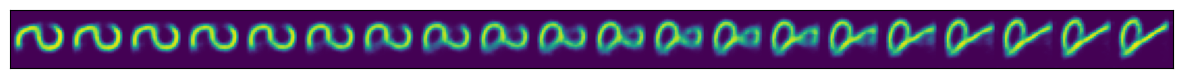

In [9]:
model.eval()
with torch.no_grad():
    x, y = next(iter(test_dl))
    x_1 = x[y == 5][1].to(device).unsqueeze(0)
    
    for idx in range(1, 10):
        x_2 = x[y == idx][1].to(device).unsqueeze(0)
        interpolate(model, x_1, x_2, n=20)